In [70]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import YGate

# NEQR - nucleotides as pixels

|  position $({X,Y})$  | necleotide | pixel color                   |
|----------------------|------------|-------------------------------|
|   ${0,0}$            |     A      |  $|10000000\rangle$           |
|   ${0,1}$            |     C      |  $|00000001\rangle$           |
|   ${1,0}$            |     G      |  $|00001100\rangle$           |
|   ${1,1}$            |     T      |  $|11111111\rangle$           |

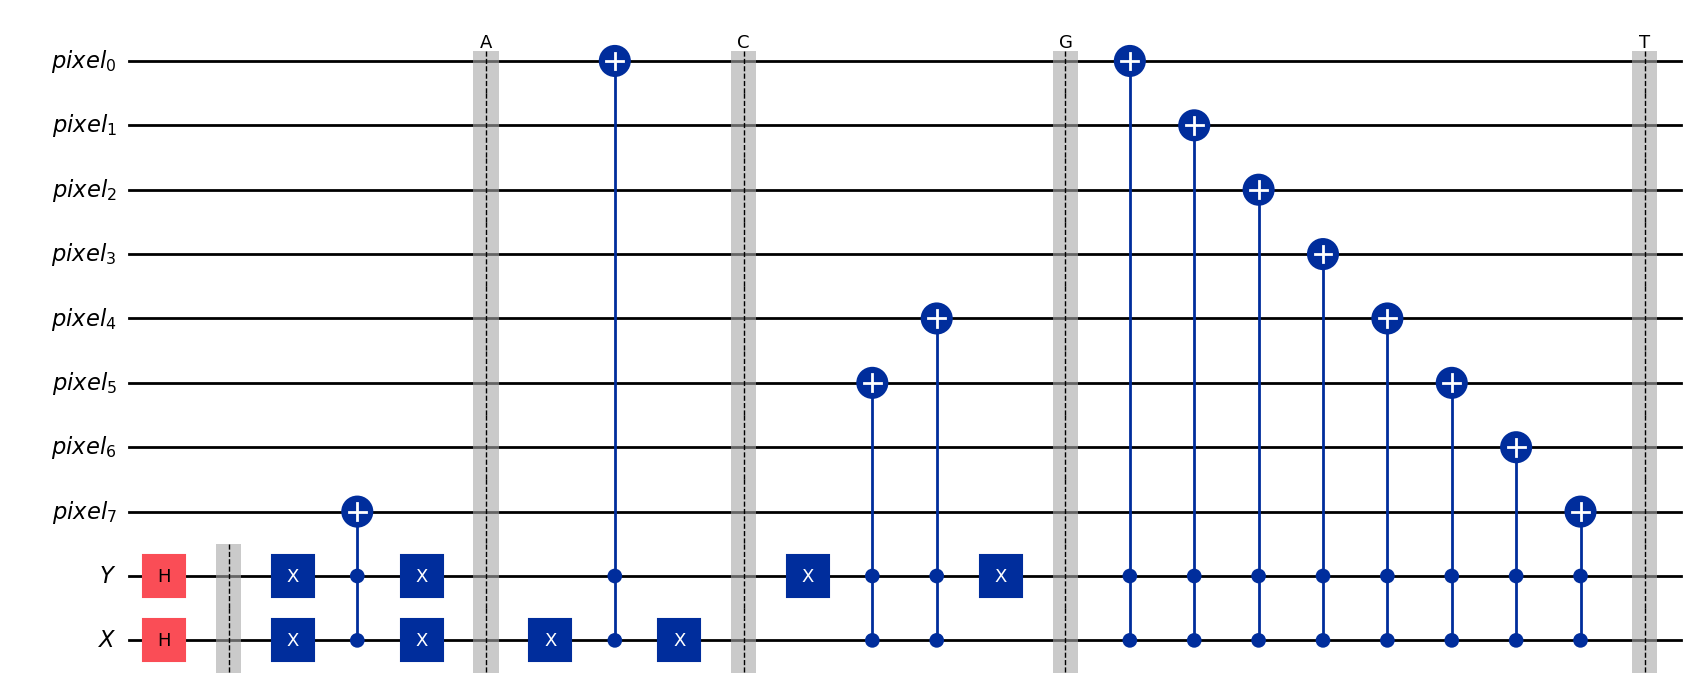

<IPython.core.display.Latex object>

In [21]:
X = QuantumRegister(1, name='X')
Y = QuantumRegister(1, name='Y')
pixels = QuantumRegister(8, name='pixel')


qc = QuantumCircuit(pixels, Y, X)

qc.h(X)
qc.h(Y)
qc.barrier(range(-1,-3,-1))

qc.x(X)
qc.x(Y)
qc.ccx(X, Y, pixels[-1])
qc.x(X)
qc.x(Y)
qc.barrier(label="A")

qc.x(X)
qc.ccx(X,Y, pixels[0])
qc.x(X)
qc.barrier(label="C")


qc.x(Y)
qc.ccx(X,Y, pixels[-3])
qc.ccx(X,Y, pixels[-4])
qc.x(Y)
qc.barrier(label="G")

for pixel in pixels:
    qc.ccx(X, Y, pixel)
qc.barrier(label="T")



display(qc.draw('mpl'))
Statevector(qc).draw('latex')

In this example, the nucleotides are encoded as 8bit grayscale color representation. The color representation was arbitraty, could be changed depending on what you want to do during processing.

# NEQR inspired bases encoding (phase encoding)

|  binary  | necleotide | phase          |
|----------|------------|----------------|
|   $00$   |     A      |  -   |
|   $01$   |     C      |  $|-\rangle$   |
|   $10$   |     G      |  $|i\rangle$   |
|   $11$   |     T      |  $|-i\rangle$  |

In [69]:
CCY = YGate().control(2)

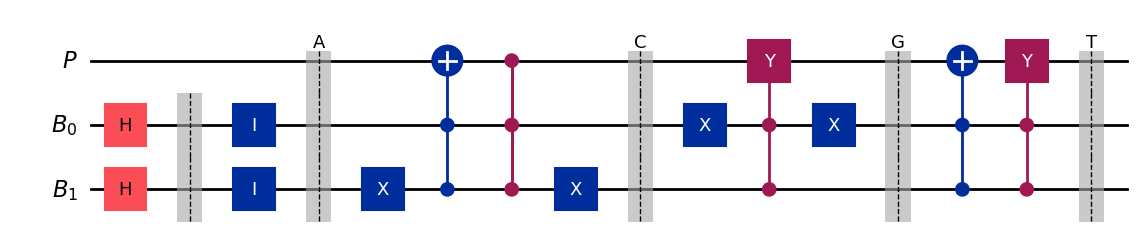

<IPython.core.display.Latex object>

In [73]:
base = QuantumRegister(2, name='B')
phase = QuantumRegister(1, name='P')

qc = QuantumCircuit(phase, base)


qc.h(base)
qc.barrier(base)

qc.id(base)
qc.barrier(label="A")


qc.x(base[1])
qc.ccx(base[0], base[1], phase)
qc.ccz(base[0], base[1], phase)
qc.x(base[1])
qc.barrier(label="C")


qc.x(base[0])
qc.append(CCY, list(range(2, -1, -1)))
qc.x(base[0])
qc.barrier(label="G")

qc.ccx(base[0], base[1], phase)
qc.append(CCY, list(range(2, -1, -1)))
qc.barrier(label="T")


display(qc.draw('mpl'))
Statevector(qc).draw('latex')

This other example shows an inspired way to encode each base in a different bloch sphere basis, so it can be distinguished measuring in both `X` and `Y`. Also it can be used with different algorithms that exploits phases. 

For further informations about quantum image processing, take a look at: [qiskit textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/image-processing-frqi-neqr.ipynb)